### Прогноз текучести *кадров*
*На основе информации о сотрудниках, а также данных о том, покинул человек компанию или нет, нам предлагается построить предсказывающий текучесть кадров (employee churn) классификатор.*

In [ ]:
import pandas as pd
import seaborn as sns
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, recall_score, f1_score

In [ ]:
df = pd.read_csv('/content/HR.csv')
df.head()

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years,department,salary
0,0.38,0.53,2,157,3,0,1,0,sales,low
1,0.80,0.86,5,262,6,0,1,0,sales,medium
2,0.11,0.88,7,272,4,0,1,0,sales,medium
3,0.72,0.87,5,223,5,0,1,0,sales,low
4,0.37,0.52,2,159,3,0,1,0,sales,low


## EDA

In [ ]:
df.shape

(14999, 10)

In [ ]:
df.isna().sum()

satisfaction_level       0
last_evaluation          0
number_project           0
average_montly_hours     0
time_spend_company       0
Work_accident            0
left                     0
promotion_last_5years    0
department               0
salary                   0
dtype: int64

In [ ]:
df.duplicated().sum()

3008

In [ ]:
df.drop_duplicates(inplace=True)

In [ ]:
df.shape

(11991, 10)

In [ ]:
df.describe()

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years
count,11991.000000,11991.000000,11991.000000,11991.000000,11991.000000,11991.000000,11991.000000,11991.000000
mean,0.629658,0.716683,3.802852,200.473522,3.364857,0.154282,0.166041,0.016929
std,0.241070,0.168343,1.163238,48.727813,1.330240,0.361234,0.372133,0.129012
min,0.090000,0.360000,2.000000,96.000000,2.000000,0.000000,0.000000,0.000000
25%,0.480000,0.570000,3.000000,157.000000,3.000000,0.000000,0.000000,0.000000
50%,0.660000,0.720000,4.000000,200.000000,3.000000,0.000000,0.000000,0.000000
75%,0.820000,0.860000,5.000000,243.000000,4.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,7.000000,310.000000,10.000000,1.000000,1.000000,1.000000


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11991 entries, 0 to 11999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   satisfaction_level     11991 non-null  float64
 1   last_evaluation        11991 non-null  float64
 2   number_project         11991 non-null  int64  
 3   average_montly_hours   11991 non-null  int64  
 4   time_spend_company     11991 non-null  int64  
 5   Work_accident          11991 non-null  int64  
 6   left                   11991 non-null  int64  
 7   promotion_last_5years  11991 non-null  int64  
 8   department             11991 non-null  object 
 9   salary                 11991 non-null  object 
dtypes: float64(2), int64(6), object(2)
memory usage: 1.0+ MB


In [ ]:
for col in df.columns:
  print(str(col)+':', df[col].nunique())
  print(df[col].unique())
  print('-'*20)

satisfaction_level: 92
[0.38 0.8  0.11 0.72 0.37 0.41 0.1  0.92 0.89 0.42 0.45 0.84 0.36 0.78
 0.76 0.09 0.46 0.4  0.82 0.87 0.57 0.43 0.13 0.44 0.39 0.85 0.81 0.9
 0.74 0.79 0.17 0.24 0.91 0.71 0.86 0.14 0.75 0.7  0.31 0.73 0.83 0.32
 0.54 0.27 0.77 0.88 0.48 0.19 0.6  0.12 0.61 0.33 0.56 0.47 0.28 0.55
 0.53 0.59 0.66 0.25 0.34 0.58 0.51 0.35 0.64 0.5  0.23 0.15 0.49 0.3
 0.63 0.21 0.62 0.29 0.2  0.16 0.65 0.68 0.67 0.22 0.26 0.99 0.98 1.
 0.52 0.93 0.97 0.69 0.94 0.96 0.18 0.95]
--------------------
last_evaluation: 65
[0.53 0.86 0.88 0.87 0.52 0.5  0.77 0.85 1.   0.54 0.81 0.92 0.55 0.56
 0.47 0.99 0.51 0.89 0.83 0.95 0.57 0.49 0.46 0.62 0.94 0.48 0.8  0.74
 0.7  0.78 0.91 0.93 0.98 0.97 0.79 0.59 0.84 0.45 0.96 0.68 0.82 0.9
 0.71 0.6  0.65 0.58 0.72 0.67 0.75 0.73 0.63 0.61 0.76 0.66 0.69 0.37
 0.64 0.39 0.41 0.43 0.44 0.36 0.38 0.4  0.42]
--------------------
number_project: 6
[2 5 7 6 4 3]
--------------------
average_montly_hours: 215
[157 262 272 223 159 153 247 259 224 142 1

## Визуальный анализ

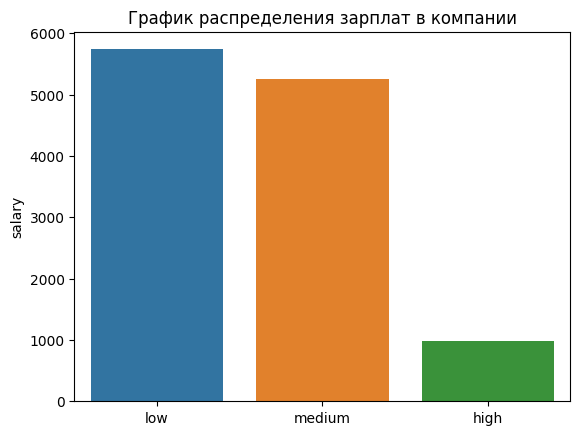

In [ ]:
sns.barplot(x = df.salary.unique(), y = df.salary.value_counts())
plt.title('График распределения зарплат в компании')
plt.show()

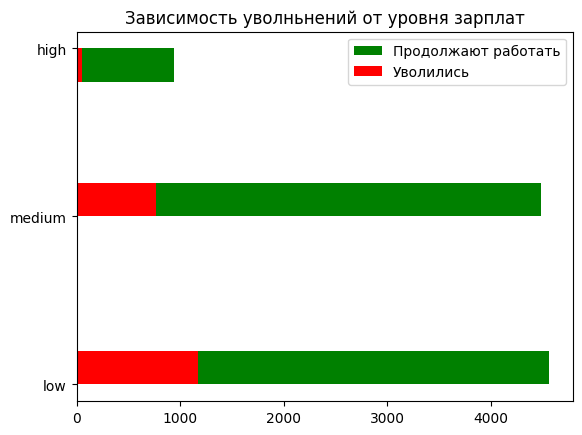

In [ ]:
plt.hist(df.salary.loc[df.left==0], orientation='horizontal', color='green')
plt.hist(df.salary.loc[df.left==1], orientation='horizontal', color='red')
plt.legend(labels=['Продолжают работать', "Уволились"])
plt.title('Зависимость уволньнений от уровня зарплат')
plt.show()

**Так, можно заметитить, что люди с маленькой зарплатой увольняются чаще тех, у кого средняя или высокая заработная плата**

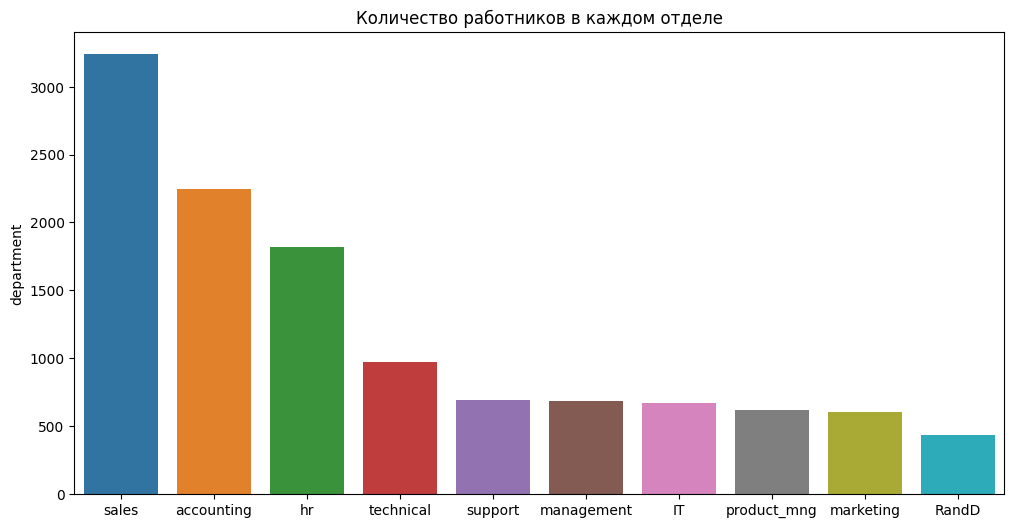

In [ ]:
plt.figure(figsize=(12,6))
sns.barplot(x = df.department.unique(), y = df.department.value_counts())
plt.title('Количество работников в каждом отделе')
plt.show()

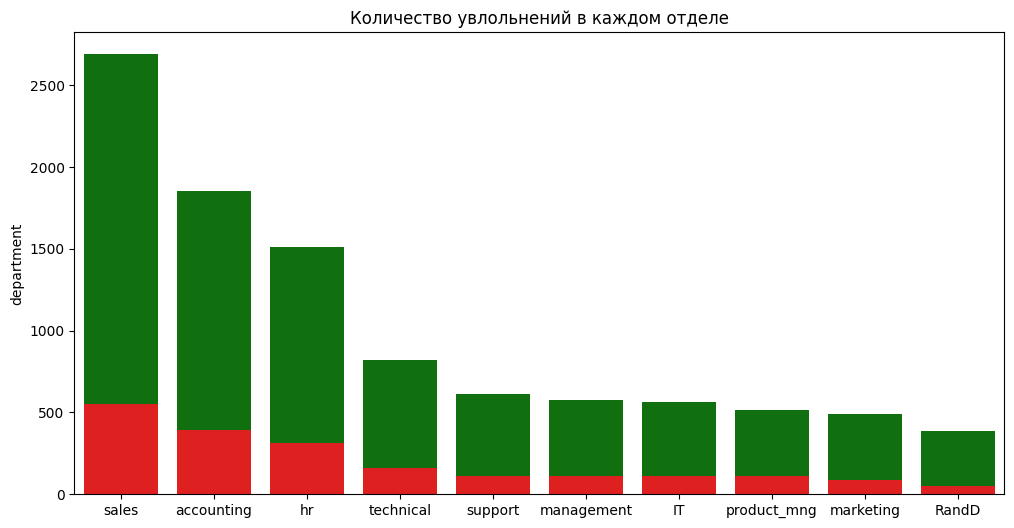

In [ ]:
plt.figure(figsize=(12,6))
sns.barplot(x = df.department.unique(), y = df.department.loc[df.left==0].value_counts(), color='green')
sns.barplot(x = df.department.unique(), y = df.department.loc[df.left==1].value_counts(), color='red')
plt.title('Количество увлольнений в каждом отделе')
plt.show()

**Из графика видно, что увольнения примерно одинаково распределены по каждому отделу, значит это не оказывает сильного внимания на увольнение**

In [ ]:
outcome_time_spend_company = pd.crosstab(index = df['left'],
                                         columns = df['time_spend_company'],
                                         normalize = 'index')

outcome_time_spend_company.index = ['Продолжает работать', 'Уволился']


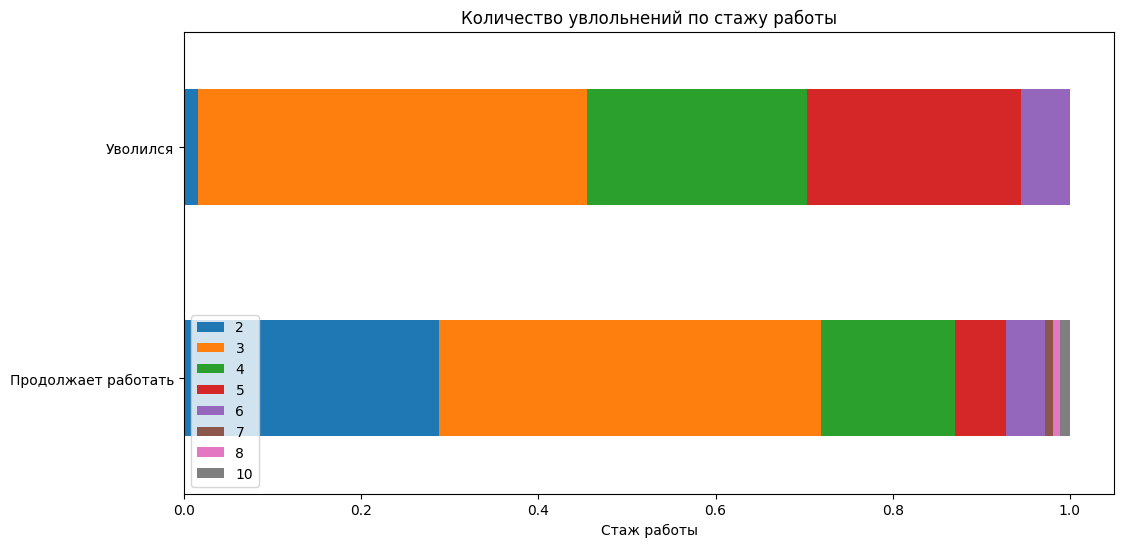

In [ ]:
outcome_time_spend_company.plot.barh(stacked = True,figsize=(12,6))
plt.title('Количество увлольнений по стажу работы')
plt.xlabel('Стаж работы')
plt.legend(loc='lower left')
plt.show()

**Те, кто работает 7 лет и более - не увольняются**

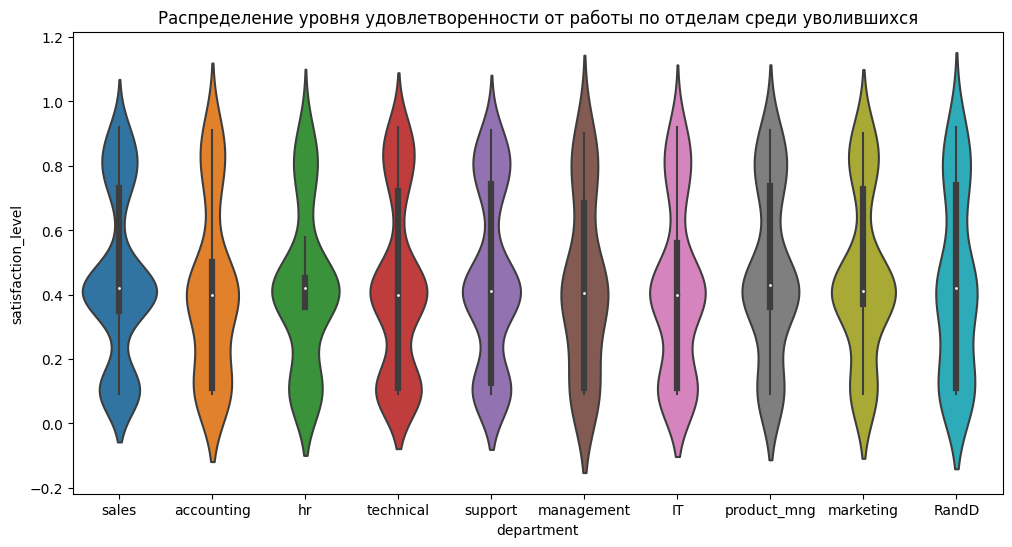

In [ ]:
plt.figure(figsize=(12,6))
sns.violinplot(x = df.department.loc[df.left==1], y = df.satisfaction_level.loc[df.left==1])
plt.title('Распределение уровня удовлетворенности от работы по отделам среди уволившихся')
plt.show()

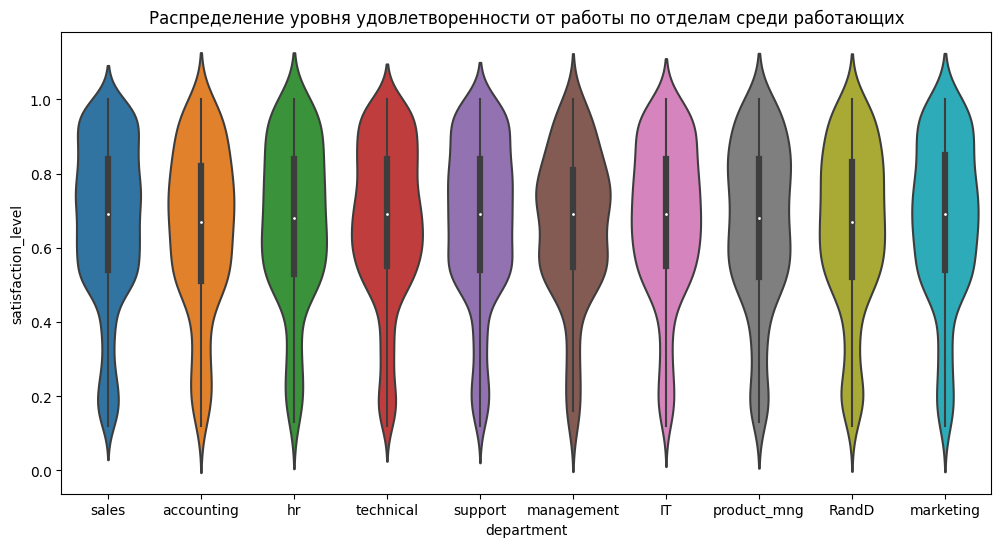

In [ ]:
plt.figure(figsize=(12,6))
sns.violinplot(x = df.department.loc[df.left==0], y = df.satisfaction_level.loc[df.left==0])
plt.title('Распределение уровня удовлетворенности от работы по отделам среди работающих')
plt.show()

**Таким образом, если работник оценивает свой уровень удовлетворенности работой примерно 0.4, то с большой вероятностью можно сказать, что он скоро уволится**

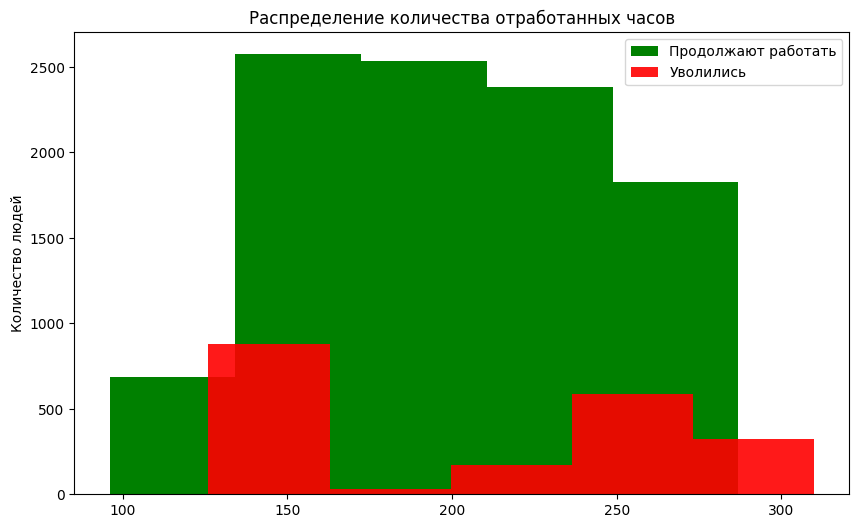

In [ ]:
bins=5
plt.figure(figsize=(10,6))
plt.hist(df.average_montly_hours.loc[df.left==0], bins, color='green')
plt.hist(df.average_montly_hours.loc[df.left==1], bins, color='red', alpha=0.9)
plt.title('Распределение количества отработанных часов')
plt.ylabel('Количество людей')
plt.legend(labels=['Продолжают работать', "Уволились"])
plt.show()

**Люди, явно перерабатывающие норму часов, увольняются чаще**

In [ ]:
df1 = df.loc[df.left==0].groupby(['department']).agg({'average_montly_hours': ['mean']}).reset_index()
df2 = df.loc[df.left==1].groupby(['department']).agg({'average_montly_hours': ['mean']}).reset_index()

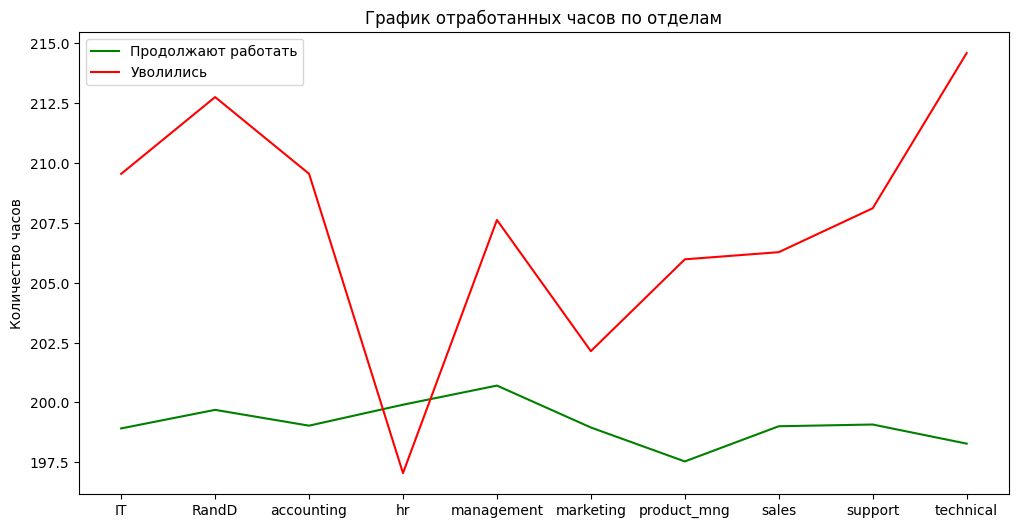

In [ ]:
plt.figure(figsize=(12,6))
plt.plot(df1.department, df1.average_montly_hours, color='green')
plt.plot(df2.department, df2.average_montly_hours, color='red')
plt.title('График отработанных часов по отделам')
plt.ylabel('Количество часов')
plt.legend(labels=['Продолжают работать', "Уволились"])
plt.show()

**Отсюда видно, что уволившиеся значительно перерабатывали**

In [ ]:
df_34 = df.copy()
df_34.salary = df_34.salary.map({'low':1, 'medium':2, 'high':3})
df3 = df_34.loc[df.left==0].groupby(['department']).agg({'salary': ['mean']}).reset_index()
df4 = df_34.loc[df.left==1].groupby(['department']).agg({'salary': ['mean']}).reset_index()

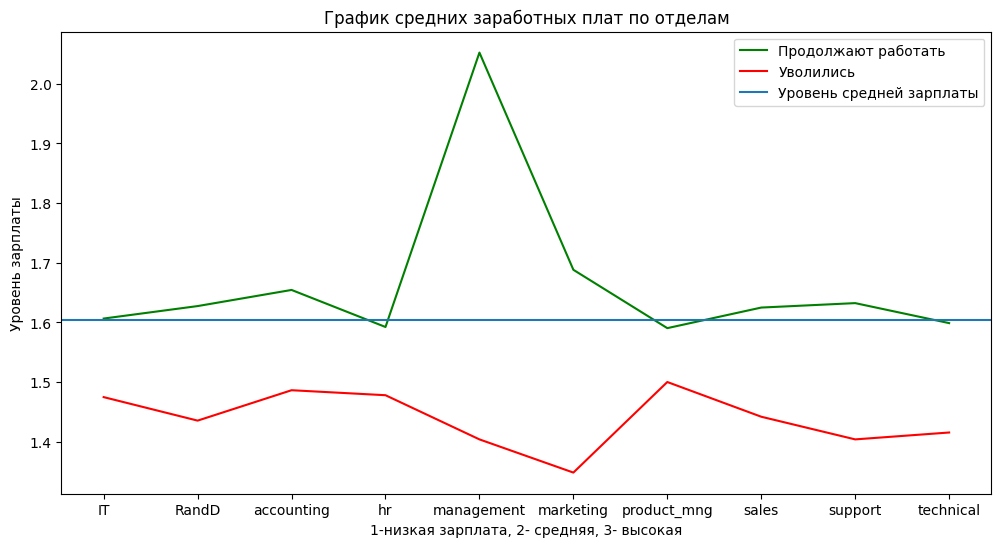

In [ ]:
plt.figure(figsize=(12,6))
plt.plot(df3.department, df3.salary, color='green')
plt.plot(df4.department, df4.salary, color='red')
plt.axhline(df_34.salary.mean())
plt.title('График средних заработных плат по отделам')
plt.ylabel('Уровень зарплаты')
plt.xlabel('1-низкая зарплата, 2- средняя, 3- высокая')
plt.legend(labels=['Продолжают работать', "Уволились", 'Уровень средней зарплаты'])
plt.show()

**Деньги - не последняя мотивация для работы у сотрудников, поэтому если они не получают высокую плату за труд, то ищут место получше**

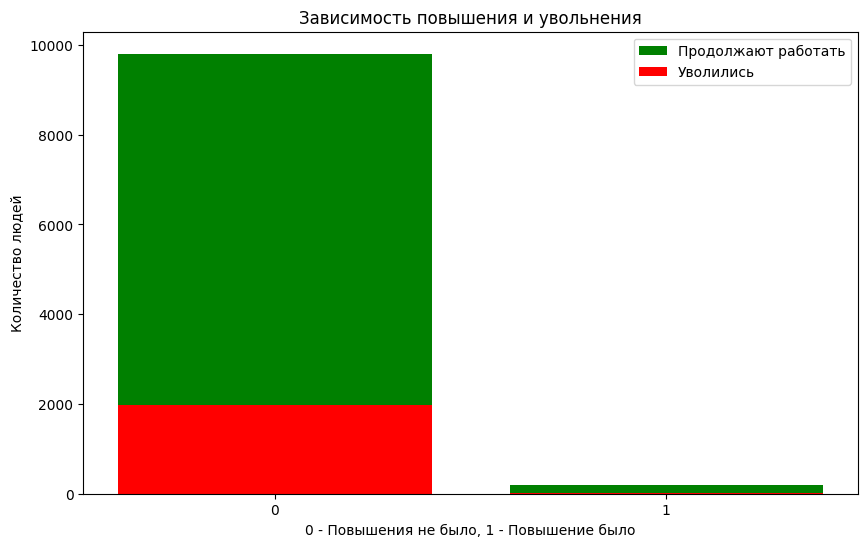

In [ ]:
plt.figure(figsize=(10,6))
plt.bar(df.promotion_last_5years.loc[df.left==0].unique(), height = df.promotion_last_5years.loc[df.left==0].value_counts(), color='green')
plt.bar(df.promotion_last_5years.loc[df.left==1].unique(), height = df.promotion_last_5years.loc[df.left==1].value_counts(), color='red')
#plt.ylim([0,4000])
plt.xticks((0,1))
plt.title('Зависимость повышения и увольнения')
plt.legend(labels=['Продолжают работать', "Уволились"])
plt.xlabel('0 - Повышения не было, 1 - Повышение было')
plt.ylabel('Количество людей')
plt.show()

**Повышения не сильно влияют на желание сотрудника остаться работать**

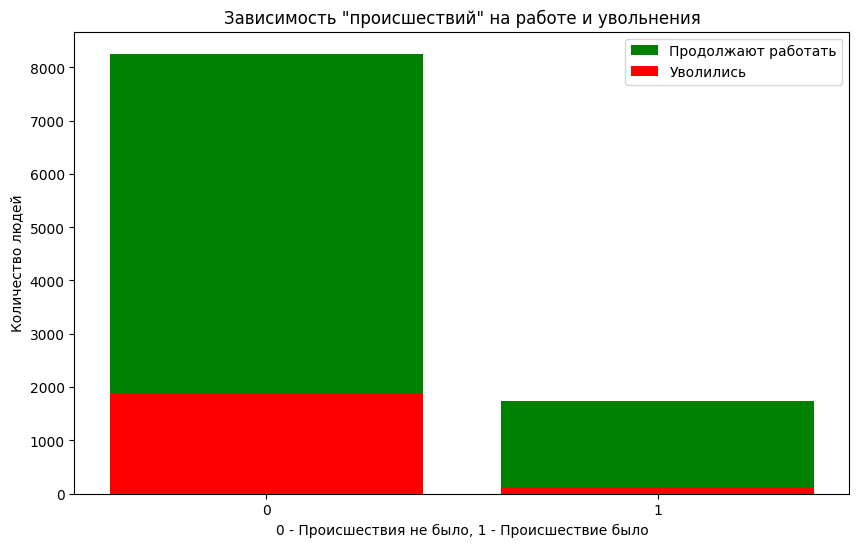

In [ ]:
plt.figure(figsize=(10,6))
plt.bar(df.Work_accident.loc[df.left==0].unique(), height = df.Work_accident.loc[df.left==0].value_counts(), color='green')
plt.bar(df.Work_accident.loc[df.left==1].unique(), height = df.Work_accident.loc[df.left==1].value_counts(), color='red')
plt.xticks((0,1))
plt.title('Зависимость "происшествий" на работе и увольнения')
plt.legend(labels=['Продолжают работать', "Уволились"])
plt.xlabel('0 - Происшествия не было, 1 - Происшествие было')
plt.ylabel('Количество людей')
plt.show()

**Происшествия мало влияют на увольнения**

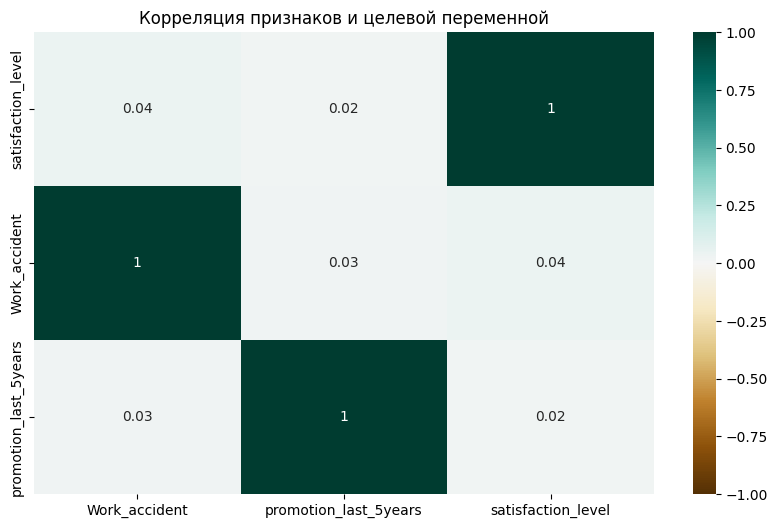

In [ ]:
plt.figure(figsize=(10,6))
sns.heatmap(df[['Work_accident', 'promotion_last_5years', 'satisfaction_level']].corr().sort_values(by='satisfaction_level', ascending=False), vmin=-1, vmax=1, annot=True, cmap='BrBG')
plt.title('Корреляция происшествия, повышений и уровня удовлетворенности')
plt.show()

<ipython-input-83-bee73e928a9e>:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(df.corr()[['left']].sort_values(by='left', ascending=False), vmin=-1, vmax=1, annot=True, cmap='BrBG')


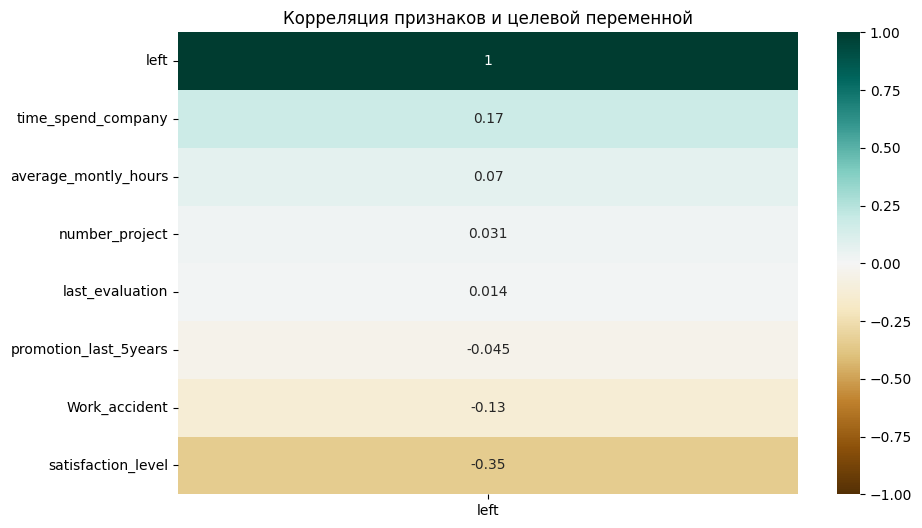

In [ ]:
plt.figure(figsize=(10,6))
sns.heatmap(df.corr()[['left']].sort_values(by='left', ascending=False), vmin=-1, vmax=1, annot=True, cmap='BrBG')
plt.title('Корреляция признаков и целевой переменной')
plt.show()

## Препроцессинг

In [ ]:
data = df.join(pd.get_dummies(df.department))
data.drop(columns='department', inplace=True)
data.salary = data.salary.map({'low':1, 'medium':2, 'high':3})

In [ ]:
data.head()

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years,salary,IT,RandD,accounting,hr,management,marketing,product_mng,sales,support,technical
0,0.38,0.53,2,157,3,0,1,0,1,0,0,0,0,0,0,0,1,0,0
1,0.80,0.86,5,262,6,0,1,0,2,0,0,0,0,0,0,0,1,0,0
2,0.11,0.88,7,272,4,0,1,0,2,0,0,0,0,0,0,0,1,0,0
3,0.72,0.87,5,223,5,0,1,0,1,0,0,0,0,0,0,0,1,0,0
4,0.37,0.52,2,159,3,0,1,0,1,0,0,0,0,0,0,0,1,0,0


In [ ]:
data.left.value_counts()

0    10000
1     1991
Name: left, dtype: int64

In [ ]:
scaler = StandardScaler()
sc_data = pd.DataFrame(scaler.fit_transform(data), columns=data.columns)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(data.drop(columns='left'), data.left, random_state=42, test_size=0.3)
X_train_sc, X_test_sc, y_train_sc, y_test_sc = train_test_split(sc_data.drop(columns='left'), data.left, random_state=42, test_size=0.3)

## Построение предсказательных моделей

**1. Модель логистической регрессии**

In [ ]:
model_LR = LogisticRegression()
model_LR.fit(X_train_sc, y_train_sc)
y_pr_LR = model_LR.predict(X_test_sc)

In [ ]:
accuracy_score(y_test, y_pr_LR), recall_score(y_test, y_pr_LR), f1_score(y_test, y_pr_LR)

(0.8287937743190662, 0.1625207296849088, 0.2413793103448276)

**2. Модель случайного леса**

In [ ]:
model_RF = RandomForestClassifier(n_estimators=1000)
model_RF.fit(X_train, y_train)
y_pr_RF = model_RF.predict(X_test)

In [ ]:
accuracy_score(y_test, y_pr_RF), recall_score(y_test, y_pr_RF), f1_score(y_test, y_pr_RF)

(0.981100611450806, 0.9071310116086235, 0.9414802065404476)

**3. Метод опорных векторов**

In [ ]:
model_SVC = SVC()
model_SVC.fit(X_train_sc, y_train_sc)
y_pr_SVC = model_SVC.predict(X_test_sc)

In [ ]:
accuracy_score(y_test_sc, y_pr_SVC), recall_score(y_test_sc, y_pr_SVC), f1_score(y_test_sc, y_pr_SVC)

(0.9546970539188439, 0.8656716417910447, 0.8649544324772163)

In [ ]:
parameters = {'kernel':('linear', 'rbf', 'poly'), 'C':[1, 10], 'degree': (1, 3, 5)}

clf = GridSearchCV(model_SVC, parameters, n_jobs=-1)
clf.fit(X_train_sc, y_train_sc)
y_pr_SVC1 = clf.predict(X_test_sc)

In [ ]:
clf.best_params_

{'C': 10, 'degree': 1, 'kernel': 'rbf'}

In [ ]:
accuracy_score(y_test_sc, y_pr_SVC1), recall_score(y_test_sc, y_pr_SVC1), f1_score(y_test_sc, y_pr_SVC1)

(0.9644246803779878, 0.8839137645107794, 0.8927973199329984)

**4. Модель градиентного бустинга**

In [ ]:
model_XGB = XGBClassifier()
model_XGB.fit(X=X_train, y= y_train)
y_pr_XGB = model_XGB.predict(X_test)

In [ ]:
accuracy_score(y_test, y_pr_XGB), recall_score(y_test, y_pr_XGB), f1_score(y_test, y_pr_XGB)

(0.980544747081712, 0.9137645107794361, 0.9402730375426621)

## Заключение

По результатам проведенной работы, было выявлено:

1.   Лишь малая часть работников получает высокую заработную плату, средняя и низкая - распределены поровну
2.   Люди с малой зарплатой увольняются чаще, чем со средней и, тем более, высокой
3.   Среди уволившихся уровень удовлетворенности работой  составляют, в среднем, около 0.4, когда среди работающих - 0.7. Следовательно, когда удовлетворенность сотрудника снижается ниже 0.5, следует принмать меры
4.   Среди уволившихся большую часть составляли люди с переработками - 250 и более рабочих часов в месяц, и, в целом, в компании бОльшая часть людей перерабатывает - на это стоит обратить внимание
5.   Те, кто получают зарплату ниже средней по компании - гарантированно увольняются
6.   Повышения, происшествия не сильно влияют на увольнения сотрудников
7.   Люди, отработавшие более 7 лет, не увольняются

Таким образом, основными аспектами на которые стоит обращать внимание HR-менеджеру, явлюятся уровень удовлетворенности условиями труда и стаж работы.

В ходе проекта была построена модель градиентного бустинга, предсказывающая увольнение сотрудника по метрике F1 с точностью - 94%

